In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

1. The accompanying spreadsheet has 650 weeks of historical Treasury spot rate
data. The first column is the week number. The other columns are Treasury spot
rates (expressed in percentage form—remember to convert them into decimal form)
for maturities of 0.25, 2.00, 3.00, 5.00, 7.00, and 10.00 years.



2. The object of this homework exercise is to calibrate the two-factor Vasicek Model
(the N2 Model) using this historical term structure data. This is done by solving
for the six parameters of the N2 model αX , βX , σX , αY , βY , and σY . Note that
these parameters are assumed to be constants across all 650 weeks. We also need to
solve for the state variables Xt and Yt. Note that these vary over time and will have
different values each week. In total, the object is to solve for the six parameters, the
650 values of Xt, and the 650 values Yt (a total of 1306 numbers) that best calibrate
the N2 Model to the historical data.


3. Recall from the class discussion that in the two-factor Vasicek Model, the price
of a zero-coupon bond can be expressed as <br>
$D(T) = A_X(T)A_B(T) exp(−B_X(T)X − B_Y(T)Y)$ <br>
where the A(T) and B(T) functions are given by the Vasicek model. The functions
$A_X(T)$ and $B_X(T)$ use the $\alpha_X, \beta_X$, and $\sigma_X$ parameters from the dynamics of X.
The functions $A_Y(T)$ and $B_Y(T)$ use the $\alpha_Y, \beta_Y$, and $\sigma_Y$ parameters from the
dynamics of Y.


4. In turn, this implies that the continuously compounded spot rate for a zero-coupon
bond with a maturity of T <br>
$−\frac{ln A_X(T)}{T}
 − \frac{ln A_Y(T)}{T} + \frac{B_X(T)}{T} Xt + \frac{B_Y(T)}{T} Yt$ <br>
 Note that given the six parameters and a value of T , the functions AX (T ), BX (T ),
AY (T ), and BY (T ) are fully determined and the above equation for the spot rate is
simply a linear equation in Xt and Yt.

5. The calibration of the model can be done using the following multi-step algorithm.

A. First, pick a trial set of the six parameters αX , βX , σX , αY , βY , and σY .

B. Second, for the first week in the sample, assume that the N2 model fits the
0.25 and 10.00 year spot rates exactly. Denote these two spot rates as r0.25
and r10.00. This assumption implies that
<br> $r_{0.25} = −\frac{ln A_X(0.25)}{0.25}
 − \frac{ln A_Y(0.25)}{0.25} + \frac{B_X(0.25)}{0.25} Xt + \frac{ln B_Y(0.25)}{0.25} Yt$ <br>
$r_{10.00} = −\frac{ln A_X(10.00)}{10.00}
 − \frac{ln A_Y(10.00)}{10.00} + \frac{B_X(10.00)}{10.00} Xt + \frac{B_Y(10.00)}{10.00} Yt$ <br>
Since the values of r are observed, and the A and B functions are determined, this represents a simple system of two linear equations in the two
unknowns X1 and Y1. Thus, you can solve directly for the values of X1 and
Y1 using basic algebra without having to do an optimization.








C. Once you have the implied values of X1 and Y1, you can then use the N2
Model to solve for the model values of the other four spot rates in the
data set for week one (the two-, three-, five, and seven-year spot rates). In
general, even though the N2 Model is calibrated by fitting exactly to the
0.25 and 10.00 year spot rates, the model will not fit these other four spot
rates exactly. Compute the squared difference between the actual spot rate
and the N2 Model implied spot rate for each of these four rates. This gives
us four squared differences for week one.

D. Third, repeat this process for all 650 weeks in the sample. This gives us
the 650 values of Xt and Yt, t = 1, 2, . . . , 650 as well as 650 ×4 squared differences.

6. To make the process easier, you can assume that αY = 0. This means that there
are only five parameters to optimize over.

In [ ]:
tsdata = pd.read_excel("Homework_5_Data.xlsx")
tsdata = tsdata.drop(tsdata.columns[0], axis = 1)
tsdata.set_index('Week',inplace=True)
tsdata.columns = [0.25, 2, 3, 5, 7, 10]
tsdata = tsdata.apply(pd.to_numeric, errors='coerce')/100

In [ ]:
class N2Model:
    def __init__(self, params):
        self.alpha_X = params[0]
        self.alpha_Y = 0
        self.beta_X = params[1]
        self.beta_Y = params[2]
        self.sigma_X = params[3]
        self.sigma_Y = params[4]
        self.times = [2, 3, 5, 7]
        self.times_list = np.arange(0.5, 10+0.5, 0.5)

    def logA_X(self, time):
        return ((self.sigma_X**2 / (2 * self.beta_X**2) - self.alpha_X / self.beta_X) * time +
                      (self.alpha_X / self.beta_X**2 - self.sigma_X**2 / self.beta_X**3) * (1 - np.exp(-1 * self.beta_X * time)) +
                      (self.sigma_X**2 / (4 * self.beta_X**3)) * (1 - np.exp(-2 * self.beta_X * time)))

    def logA_Y(self, time):
        return ((self.sigma_Y**2 / (2 * self.beta_Y**2) - self.alpha_Y / self.beta_Y) * time +
                      (self.alpha_Y / self.beta_Y**2 - self.sigma_Y**2 / self.beta_Y**3) * (1 - np.exp(-1 * self.beta_Y * time)) +
                      (self.sigma_Y**2 / (4 * self.beta_Y**3)) * (1 - np.exp(-2 * self.beta_Y * time)))

    def B_X(self, time):
        return (1 - np.exp(-1 * self.beta_X * time)) / self.beta_X

    def B_Y(self, time):
        return (1 - np.exp(-1 * self.beta_Y * time)) / self.beta_Y
     
    def row_vars(self, row_num):
        left = [[self.B_X(0.25),self.B_Y(0.25)],[self.B_X(10),self.B_Y(10)]]
        right = [(tsdata.loc[row_num, 0.25]*0.25+self.logA_X(0.25)+self.logA_Y(0.25)),(tsdata.loc[row_num, 10]*10+self.logA_X(10)+self.logA_Y(10))]
        return np.linalg.solve(left, right)
    
    def discount(self, X, Y, time):
        discountfactor = np.exp(self.logA_X(time)+self.logA_Y(time)-self.B_X(time)*X-self.B_Y(time)*Y)
        return discountfactor
    
    def spot(self,df,time):
        spotrate = 2*((100-100*df[time*2])/sum(df[0:time*2]))
        return spotrate/100
    
    def diff(self,row_num):
        vars = self.row_vars(row_num)
        df_list = [self.discount(vars[0], vars[1], time) for time in self.times_list]
        spot_list = [self.spot(df_list,time) for time in self.times]

        diff_list= [self.discount(vars[0], vars[1], time) - spot_list[self.times.index(time)] for time in self.times]
        return diff_list
    
    def row_MSE(self, row_num):
        vars = self.row_vars(row_num)
        df_list = [self.discount(vars[0], vars[1], time) for time in self.times_list]
        spot_list = [self.spot(df_list,time) for time in self.times]

        error = np.sqrt(np.mean([(self.discount(vars[0], vars[1], time) - spot_list[self.times.index(time)])**2 for time in self.times]))
        return error
    
    def score(self):
        total_MSE = np.mean([self.row_MSE(row_num) for row_num in range(1,tsdata.shape[0]+1)])
        return total_MSE

In [ ]:
params0 =[0.01, 0.01, 0.01, 0.1, 0.1]
model = N2Model(params0)


In [ ]:
def objective_function(params, model):
    model.alpha_X, model.beta_X, model.beta_Y, model.sigma_X, model.sigma_Y = params
    return model.score()

result = minimize(objective_function, params0, args=(model))
optimized_params = result.x
print(optimized_params)

[ 3.97077388e+00  1.38593581e+00 -9.55467119e-01  3.25442384e+00
 -1.49293608e-07]


7. Once you have calibrated the model, graph the values of Xt and Yt and check
how well their sample moments (means, standard deviations) match those implied
by the (risk neutral) parameter estimates.

In [ ]:
optimal_model = N2Model(optimized_params)

paths = pd.DataFrame()
for r in range(1,tsdata.shape[0]+1):
    xy = optimal_model.row_vars(r)
    paths.loc[r,'X'] = xy[0]
    paths.loc[r,'Y'] = xy[1]
    paths.loc[r, [2, 3, 5, 7]] = optimal_model.diff(r)

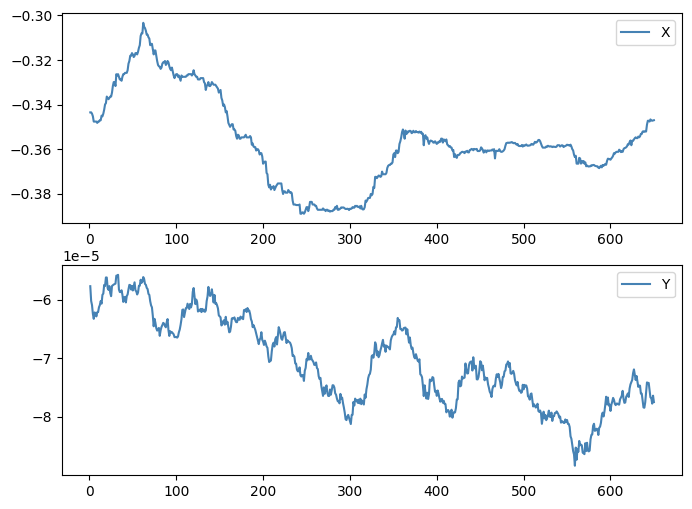

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(paths['X'],color='steelblue',label='X')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(paths['Y'],color='steelblue',label='Y')
plt.legend()
plt.show()
plt.tight_layout()

In [ ]:
stats = pd.DataFrame({
    "mean": paths[['X','Y']].mean(),
    "var": paths[['X','Y']].var()}).T
stats

,X,Y
mean,-0.356306,-7.069013e-05
var,0.000396,5.745016e-11


8. Analyze the time series properties of deviations between the spot rates and the
fitted model. How rapidly do deviations between the two-, three-, five, and seven-
year spot rates and the N2 Model implied values tend to converge? What does this
imply about the potential profitability of term structure trading strategies based on
the N2 Model?

[]

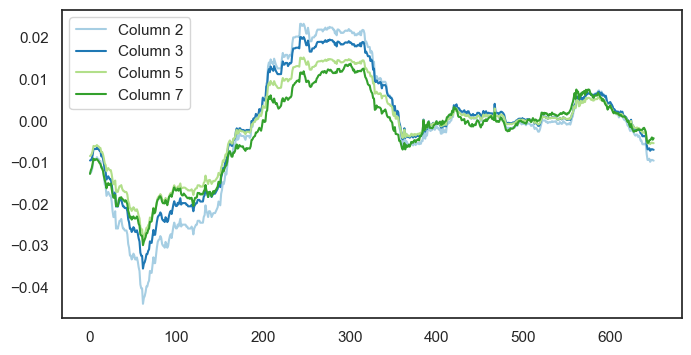

In [ ]:
sns.set(style="white",palette="Paired")
plt.figure(figsize=(8, 4))
for t in [2, 3, 5, 7]:
    plt.plot(paths[t], label=f'Column {t}')

plt.legend()
plt.plot()